In [1]:
import seaborn as sns
import metapack as mp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display 
import sklearn

%matplotlib inline
sns.set_context('notebook')
mp.jupyter.init()


In [2]:
#pkg = mp.jupyter.open_package()
pkg = mp.jupyter.open_source_package()
pkg

# COVID-19 Data
`jhu.edu-covid19-1` Last Update: 2020-03-21T19:27:44

_Covid 19 cases data from John-Hopkins, augmented and reformtted_


## Caveats

* China's minimum cases in the dataset is 548, so it's value for days sincle
  100 cases is shifted by 6 days. It's just a guess, but it looks good. 
* Countries that haven't reached 100 cases yet will have a days since 100 cases
  value that is always negative.


 

## Contacts

* **Wrangler** [Eric Busboom](mailto:eric@civicknowledge.com), [Civic Knowledge](http://civicknowledge.com)

## Resources

* ** [process_ts](notebooks/ProcessTimeseries.ipynb)**. 

## References
<ul><li> <strong><a href="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/">ts_base_url</a></strong>. Base URL for time series data</li><li> <strong><a href="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv">confirmed_ts_source</a></strong>. Source for time series of confirmed cases</li><li> <strong><a href="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv">death_ts_source</a></strong>. Source for time series of deaths</li><li> <strong><a href="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv">recov_ts_source</a></strong>. Source for time series of recoveries</li><ul>

In [3]:
conf_raw = pkg.reference('confirmed_ts_source').dataframe()

In [4]:

t = conf_raw.drop(columns=['Lat','Long']).rename(columns={'Country/Region': 'country', 'Province/State': 'province'}).fillna('')

# The countries frame sums regions of a country into whole countries. 
countries = t[(t.province != '') ].groupby('country').sum().reset_index()
countries['province'] = ''
t = pd.concat([t, countries], sort=True)

# Create a location field that uses both the country and province
t['location'] = t.apply(lambda r: f"{r.country}{' - ' if r.province else ''}{r.province}", axis=1)

# Turn the date columns int new rows
t = t.set_index(['country','province','location'])
t = t.stack().to_frame().reset_index().rename(columns={0:'confirmed','level_3':'date'})
t['date'] = pd.to_datetime(t['date'])

# Find the date at which there are more than 100 cases. 
min_date = t[t.confirmed >= 100].groupby('location').date.min().to_frame().rename(columns={'date': 'date_100'})
t = t.merge(min_date, on='location')
t['days_100'] = (t.date-t['date_100']).dt.days

# The min in this dataset for China is 548, not 100, so shift it by 6 days
# to get it to align with other countries. It's a guess, but it looks good 
t = t.copy()
t.loc[t.country == 'China', ['days_100']] = t.loc[t.country == 'China', 'days_100'] + 6
t['date_m5'] = t.date-pd.Timedelta(days=5)

t_past = t[['date', 'location', 'confirmed']].copy().rename(columns={'confirmed':'conf_m5d', 'date':'date_m5'})
t = t.merge(t_past, on=['date_m5', 'location'])

tnz = t[ (t.confirmed != t.conf_m5d) & (t.confirmed !=0) & (t.conf_m5d != 0) ]
t['rate_t5d'] = np.exp((np.log(tnz.confirmed)-np.log(tnz.conf_m5d)) / 5)-1

t.drop(columns=['date_m5', 'conf_m5d' ], inplace = True)

df = t
df.head()


,country,province,location,date,confirmed,date_100,days_100,rate_t5d
0,Thailand,,Thailand,2020-01-27,8,2020-03-15,-48,0.319508
1,Thailand,,Thailand,2020-01-28,14,2020-03-15,-47,0.360822
2,Thailand,,Thailand,2020-01-29,14,2020-03-15,-46,0.228660
3,Thailand,,Thailand,2020-01-30,14,2020-03-15,-45,0.148698
4,Thailand,,Thailand,2020-01-31,19,2020-03-15,-44,0.188865


In [5]:
t.head()


,country,province,location,date,confirmed,date_100,days_100,rate_t5d
0,Thailand,,Thailand,2020-01-27,8,2020-03-15,-48,0.319508
1,Thailand,,Thailand,2020-01-28,14,2020-03-15,-47,0.360822
2,Thailand,,Thailand,2020-01-29,14,2020-03-15,-46,0.228660
3,Thailand,,Thailand,2020-01-30,14,2020-03-15,-45,0.148698
4,Thailand,,Thailand,2020-01-31,19,2020-03-15,-44,0.188865


Text(0, 0.5, 'Rate of Growth')

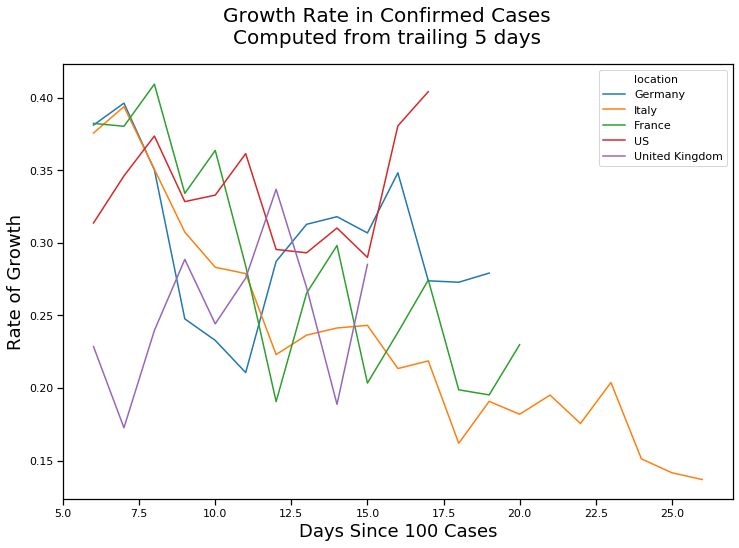

In [6]:

t = df[(df.days_100<30) & (df.days_100>5) & (df.confirmed>100)] 
t = t[t.location.isin( ['Italy','US','Germany','France', 'United Kingdom'])]

fig, ax = plt.subplots(figsize=(12,8))
fig.suptitle('Growth Rate in Confirmed Cases\nComputed from trailing 5 days', fontsize=20)

sns.lineplot(ax=ax, x='days_100',y='rate_t5d', data=t, hue='location', ci=None)
ax.set_xlabel('Days Since 100 Cases', fontsize=18)
ax.set_ylabel('Rate of Growth', fontsize=18)



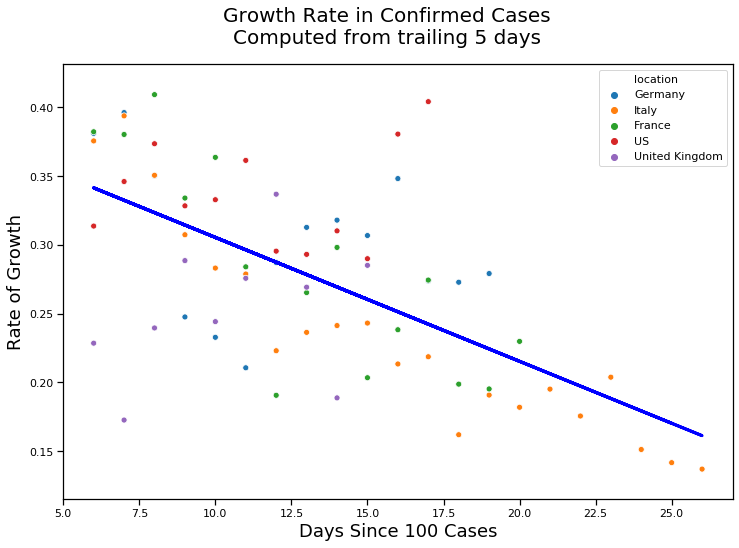

Coefficients: [[-0.00900993]] [0.39555108]
Correlation: -0.6330151605727176


In [7]:
from sklearn import  linear_model

x = t.days_100.values.reshape(len(t), 1)
y = t.rate_t5d.values.reshape(len(t), 1)

regr = linear_model.LinearRegression()
regr.fit(x, y)

fig, ax = plt.subplots(figsize=(12,8))
fig.suptitle('Growth Rate in Confirmed Cases\nComputed from trailing 5 days', fontsize=20)

sns.scatterplot(ax=ax, x='days_100',y='rate_t5d', data=t, hue='location', ci=None)
ax.plot(x, regr.predict(x), color='blue', linewidth=3)

ax.set_xlabel('Days Since 100 Cases', fontsize=18)
ax.set_ylabel('Rate of Growth', fontsize=18)

plt.show()

print('Coefficients:', regr.coef_, regr.intercept_)
print("Correlation:", t.days_100.corr(t.rate_t5d))

In [8]:
df

,country,province,location,date,confirmed,date_100,days_100,rate_t5d
0,Thailand,,Thailand,2020-01-27,8,2020-03-15,-48,0.319508
1,Thailand,,Thailand,2020-01-28,14,2020-03-15,-47,0.360822
2,Thailand,,Thailand,2020-01-29,14,2020-03-15,-46,0.228660
3,Thailand,,Thailand,2020-01-30,14,2020-03-15,-45,0.148698
4,Thailand,,Thailand,2020-01-31,19,2020-03-15,-44,0.188865
...,...,...,...,...,...,...,...,...
6907,United Kingdom,,United Kingdom,2020-03-05,116,2020-03-05,0,0.382121
6908,United Kingdom,,United Kingdom,2020-03-06,164,2020-03-05,1,0.354279
6909,United Kingdom,,United Kingdom,2020-03-07,207,2020-03-05,2,0.389255
6910,United Kingdom,,United Kingdom,2020-03-08,274,2020-03-05,3,0.399704


In [9]:
df[(df.confirmed == 0)]

,country,province,location,date,confirmed,date_100,days_100,rate_t5d
216,Canada,British Columbia,Canada - British Columbia,2020-01-27,0,2020-03-16,-49,NaN
378,Australia,Queensland,Australia - Queensland,2020-01-27,0,2020-03-19,-52,NaN
379,Australia,Queensland,Australia - Queensland,2020-01-28,0,2020-03-19,-51,NaN
486,Finland,,Finland,2020-01-27,0,2020-03-13,-46,NaN
487,Finland,,Finland,2020-01-28,0,2020-03-13,-45,NaN
...,...,...,...,...,...,...,...,...
6783,Netherlands,,Netherlands,2020-02-09,0,2020-03-06,-26,NaN
6858,United Kingdom,,United Kingdom,2020-01-27,0,2020-03-05,-38,NaN
6859,United Kingdom,,United Kingdom,2020-01-28,0,2020-03-05,-37,NaN
6860,United Kingdom,,United Kingdom,2020-01-29,0,2020-03-05,-36,NaN


In [10]:
df[df.country == 'Finland']

,country,province,location,date,confirmed,date_100,days_100,rate_t5d
486,Finland,,Finland,2020-01-27,0,2020-03-13,-46,NaN
487,Finland,,Finland,2020-01-28,0,2020-03-13,-45,NaN
488,Finland,,Finland,2020-01-29,1,2020-03-13,-44,NaN
489,Finland,,Finland,2020-01-30,1,2020-03-13,-43,NaN
490,Finland,,Finland,2020-01-31,1,2020-03-13,-42,NaN
491,Finland,,Finland,2020-02-01,1,2020-03-13,-41,NaN
492,Finland,,Finland,2020-02-10,1,2020-03-13,-32,NaN
493,Finland,,Finland,2020-02-11,1,2020-03-13,-31,NaN
494,Finland,,Finland,2020-02-12,1,2020-03-13,-30,NaN
495,Finland,,Finland,2020-02-13,1,2020-03-13,-29,NaN


In [11]:
t = df[df.country == 'Canada'].copy()
t[t.confirmed >= 100] #.groupby('location').date.min()

#.to_frame().rename(columns={'date': 'date_100'})
#t

,country,province,location,date,confirmed,date_100,days_100,rate_t5d
257,Canada,British Columbia,Canada - British Columbia,2020-03-16,103,2020-03-16,0,0.214380
258,Canada,British Columbia,Canada - British Columbia,2020-03-17,103,2020-03-16,1,0.174941
259,Canada,British Columbia,Canada - British Columbia,2020-03-18,186,2020-03-16,2,0.237846
260,Canada,British Columbia,Canada - British Columbia,2020-03-19,231,2020-03-16,3,0.292666
262,Canada,British Columbia,Canada - British Columbia,2020-03-20,271,2020-03-16,4,0.299958
2956,Canada,Ontario,Canada - Ontario,2020-03-15,104,2020-03-15,0,0.236363
2957,Canada,Ontario,Canada - Ontario,2020-03-16,177,2020-03-15,1,0.339794
2958,Canada,Ontario,Canada - Ontario,2020-03-17,185,2020-03-15,2,0.345193
2959,Canada,Ontario,Canada - Ontario,2020-03-18,221,2020-03-15,3,0.244607
2960,Canada,Ontario,Canada - Ontario,2020-03-19,257,2020-03-15,4,0.266080
